# Data Preparation and descriptive statistics

In [13]:
import helpers

## Importing consumption data

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv("ProductionConsumptionSettlement.csv", delimiter=";")

# Convert columns to appropriate data types
df['HourUTC'] = pd.to_datetime(df['HourUTC'])
df['HourDK'] = pd.to_datetime(df['HourDK'])

## Lil bit of data cleaning/prep

In [15]:
# Convert columns to numeric format (replacing commas with dots)
columns_to_convert = ['CentralPowerMWh', 'LocalPowerMWh',
                      'CommercialPowerMWh', 'LocalPowerSelfConMWh', 'OffshoreWindLt100MW_MWh',
                      'OffshoreWindGe100MW_MWh', 'OnshoreWindLt50kW_MWh',
                      'OnshoreWindGe50kW_MWh', 'HydroPowerMWh', 'SolarPowerLt10kW_MWh',
                      'SolarPowerGe10Lt40kW_MWh', 'SolarPowerGe40kW_MWh',
                      'SolarPowerSelfConMWh', 'UnknownProdMWh', 'ExchangeNO_MWh',
                      'ExchangeSE_MWh', 'ExchangeGE_MWh', 'ExchangeNL_MWh', 'ExchangeGB_MWh',
                      'ExchangeGreatBelt_MWh', 'GrossConsumptionMWh',
                      'GridLossTransmissionMWh', 'GridLossInterconnectorsMWh',
                      'GridLossDistributionMWh', 'PowerToHeatMWh']

df[columns_to_convert] = df[columns_to_convert].apply(lambda x: x.str.replace(',', '.')).astype(float)

df['Wind'] = df[['OffshoreWindLt100MW_MWh', 'OffshoreWindGe100MW_MWh', 'OnshoreWindLt50kW_MWh', 'OnshoreWindGe50kW_MWh']].sum(axis=1)
df['Hydro'] = df['HydroPowerMWh']
df['Solar'] = df[['SolarPowerLt10kW_MWh', 'SolarPowerGe10Lt40kW_MWh', 'SolarPowerGe40kW_MWh', 'SolarPowerSelfConMWh']].sum(axis=1)
df['Power'] = df[['CentralPowerMWh', 'LocalPowerMWh', 'CommercialPowerMWh', 'LocalPowerSelfConMWh']].sum(axis=1)
df['Exchange'] = df[['CentralPowerMWh', 'LocalPowerMWh', 'CommercialPowerMWh', 'LocalPowerSelfConMWh']].sum(axis=1)


# Rename nd drops
df.rename(columns={'UnknownProdMWh': 'Unknown_Production'}, inplace=True)

df.drop(['OffshoreWindLt100MW_MWh', 'OffshoreWindGe100MW_MWh', 'OnshoreWindLt50kW_MWh', 'OnshoreWindGe50kW_MWh',
         'HydroPowerMWh', 'SolarPowerLt10kW_MWh', 'SolarPowerGe10Lt40kW_MWh', 'SolarPowerGe40kW_MWh', 'SolarPowerSelfConMWh',
         'CentralPowerMWh', 'LocalPowerMWh', 'CommercialPowerMWh', 'LocalPowerSelfConMWh'], axis=1, inplace=True)

df = df[['HourUTC', 'HourDK', 'PriceArea', 'Wind', 'Hydro', 'Solar', 'Power', 'Unknown_Production',
         'ExchangeNO_MWh', 'ExchangeSE_MWh', 'ExchangeGE_MWh', 'ExchangeNL_MWh', 'ExchangeGB_MWh',
         'ExchangeGreatBelt_MWh', 'GrossConsumptionMWh', 'GridLossTransmissionMWh', 'GridLossInterconnectorsMWh',
         'GridLossDistributionMWh', 'PowerToHeatMWh']]

## fill Exhcnage NAn with 0 
df[['ExchangeNO_MWh','ExchangeSE_MWh', 'ExchangeGE_MWh', 'ExchangeNL_MWh', 'ExchangeGB_MWh', 'ExchangeGreatBelt_MWh']] = df[['ExchangeNO_MWh','ExchangeSE_MWh', 'ExchangeGE_MWh', 'ExchangeNL_MWh', 'ExchangeGB_MWh', 'ExchangeGreatBelt_MWh']].fillna(0)

# Merge the exchanges -- net exchange ish --- CHECK IF THIS IS OK --- ALSO GET BACK TO EXHCANGE GREAT BELT
df['Exchange'] = df[['ExchangeNO_MWh','ExchangeSE_MWh', 'ExchangeGE_MWh', 'ExchangeNL_MWh', 'ExchangeGB_MWh']].sum(axis=1)
exchange_columns = ['ExchangeNO_MWh', 'ExchangeSE_MWh', 'ExchangeGE_MWh', 'ExchangeNL_MWh', 'ExchangeGB_MWh']
df[exchange_columns] = df[exchange_columns].fillna(0)


df['GridLoss'] = df[['GridLossTransmissionMWh', 'GridLossInterconnectorsMWh', 'GridLossDistributionMWh','PowerToHeatMWh']].sum(axis=1)
grid_loss_columns = ['GridLossTransmissionMWh', 'GridLossInterconnectorsMWh', 'GridLossDistributionMWh', 'PowerToHeatMWh']
df['GridLoss'] = df[grid_loss_columns].sum(axis=1)

## finally drop the columns:
df.drop(['ExchangeNO_MWh', 'ExchangeSE_MWh', 'ExchangeGE_MWh', 'ExchangeNL_MWh', 'ExchangeGB_MWh', 'GridLossTransmissionMWh', 'GridLossInterconnectorsMWh',
         'GridLossDistributionMWh', 'PowerToHeatMWh'], axis=1, inplace=True)

## Now onto weather data

In [16]:
import requests
#data collected from https://open-meteo.com/ --- code is inspired from documentation

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"

params = {
    "latitude": 56.2639,  # Latitude of Denmark
    "longitude": 9.5018,  # Longitude of Denmark
    "start_date": "2022-01-01",
    "end_date": "2024-03-01",
	"hourly": ["temperature_2m", "precipitation", "cloud_cover", "wind_speed_10m"],
	"wind_speed_unit": "ms",
	"timezone": "Europe/Berlin"
}

# Make the HTTP request
response = requests.get(url, params=params)
data = response.json()

# Process hourly data. The order of variables needs to be the same as requested.
hourly = data['hourly']
hourly_temperature_2m = hourly['temperature_2m']
hourly_precipitation = hourly['precipitation']
hourly_cloud_cover = hourly['cloud_cover']
hourly_wind_speed_10m = hourly['wind_speed_10m']

df_weather = pd.DataFrame()
df_weather['Datetime'] = pd.to_datetime(hourly['time'])
df_weather['hourly_temperature_2m'] = hourly_temperature_2m #°C
df_weather['precipitation'] = hourly_precipitation #mm
df_weather['cloud_cover'] = hourly_cloud_cover #% of sky
df_weather['hourly_wind_speed_10m'] = hourly_wind_speed_10m #already in m/s      #[speed/3.6 for speed in hourly_wind_speed_10m] #km/h to m/s

# df_weather.head()

In [26]:
df

,HourUTC,HourDK,PriceArea,Wind,Hydro,Solar,Power,Unknown_Production,ExchangeGreatBelt_MWh,GrossConsumptionMWh,Exchange,GridLoss
0,2021-12-31 23:00:00,2022-01-01 00:00:00,DK1,2055.764409,1.637731,0.074532,609.812186,0.000000,385.2,2196.288858,-856.200000,360.817724
1,2021-12-31 23:00:00,2022-01-01 00:00:00,DK2,1114.281163,0.000000,0.022679,789.892353,5.171680,-390.7,1415.517875,-103.150000,137.254178
2,2022-01-01 00:00:00,2022-01-01 01:00:00,DK1,2039.635142,1.641966,0.068892,550.685591,0.000000,356.5,2206.261591,-742.270000,417.870739
3,2022-01-01 00:00:00,2022-01-01 01:00:00,DK2,1206.825676,0.000000,0.022142,644.458331,4.867611,-361.4,1394.053760,-100.720000,150.287094
4,2022-01-01 01:00:00,2022-01-01 02:00:00,DK1,1940.061145,1.637933,0.068020,639.051325,0.000000,293.3,2147.808423,-726.310000,413.053915
...,...,...,...,...,...,...,...,...,...,...,...,...
37915,2024-02-29 20:00:00,2024-02-29 21:00:00,DK2,1279.730675,0.000000,0.429421,669.755253,2.427750,-598.0,1767.729341,413.386242,170.688716
37916,2024-02-29 21:00:00,2024-02-29 22:00:00,DK2,1233.604793,0.000000,0.437171,605.839292,1.684360,-598.1,1654.056866,410.591250,167.407413
37917,2024-02-29 21:00:00,2024-02-29 22:00:00,DK1,2690.470361,3.945176,0.240603,664.748849,0.336510,587.9,2844.056218,-1103.585281,347.810069
37918,2024-02-29 22:00:00,2024-02-29 23:00:00,DK1,2697.359459,3.869114,0.224664,705.713664,0.267110,588.0,2695.124304,-1300.309707,336.544217


In [17]:
# Merge the DataFrames on 'HourDK' and 'Datetime'
merged_df = pd.merge(df, df_weather, left_on='HourDK', right_on='Datetime', how='left')
merged_df.drop('Datetime', axis=1, inplace=True)

missing_values_exist = False

for column in merged_df.columns:
    num_missing = merged_df[column].isnull().sum()
    if num_missing > 0:
        missing_values_exist = True
        print(f"Column '{column}' has {num_missing} missing values.")
if not missing_values_exist:
    print("No missing vlaues found.")

#!!!!!!!! Remove rows where PriceArea == 'DK1'
merged_df_DK1 = merged_df[merged_df['PriceArea'] != 'DK2']
merged_df_DK2 = merged_df[merged_df['PriceArea'] != 'DK1']

merged_df_DK1.head(2)
merged_df_DK1.describe()

No missing vlaues found.


,HourUTC,HourDK,Wind,Hydro,Solar,Power,Unknown_Production,ExchangeGreatBelt_MWh,GrossConsumptionMWh,Exchange,GridLoss,hourly_temperature_2m,precipitation,cloud_cover,hourly_wind_speed_10m
count,18960,18960,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000
mean,2023-01-30 22:30:00,2023-01-31 00:02:57.721518848,1660.624711,2.146363,220.149608,831.214784,0.058473,-0.640153,2598.753557,-114.800230,323.233667,8.657078,0.108486,59.599736,4.320082
min,2021-12-31 23:00:00,2022-01-01 00:00:00,0.821767,0.084128,0.052065,111.388990,0.000000,-605.700000,1460.655524,-3204.469108,114.372566,-13.000000,0.000000,0.000000,0.000000
25%,2022-07-17 10:45:00,2022-07-17 12:45:00,558.582047,1.182360,0.184747,476.733112,0.000014,-299.025000,2220.891603,-849.942500,190.528539,3.800000,0.000000,23.000000,2.750000
50%,2023-01-30 22:30:00,2023-01-30 23:30:00,1451.593129,1.861568,5.324500,678.285237,0.028042,-0.300000,2605.209496,-42.530000,245.113270,8.200000,0.000000,68.000000,4.050000
75%,2023-08-16 10:15:00,2023-08-16 12:15:00,2566.271837,2.990048,276.965405,1061.682403,0.099400,303.600000,2945.405372,678.048425,399.809874,13.800000,0.000000,100.000000,5.590000
max,2024-02-29 22:00:00,2024-02-29 23:00:00,4825.248284,5.555328,1994.581960,2695.634735,0.936407,590.500000,4040.558877,2495.900000,1075.440288,32.200000,8.300000,100.000000,13.970000
std,NaN,NaN,1235.971708,1.101743,382.758363,482.921318,0.076109,364.367113,497.204147,1046.197978,184.245745,6.639388,0.382470,38.508783,2.057996


When modelling Denmark we have two areas, DK1 and DK2. DK1 being west Denmark. 

It gets complex to model the interactions between these two areas as 'one' system due to their energy exchange, as such we only model one of the DK areas and treat the other as an exchange later when we do modelling. <-- this is not completely set up in the code, but we will do descriptive stats on one of the areas:

## Descriptive stats

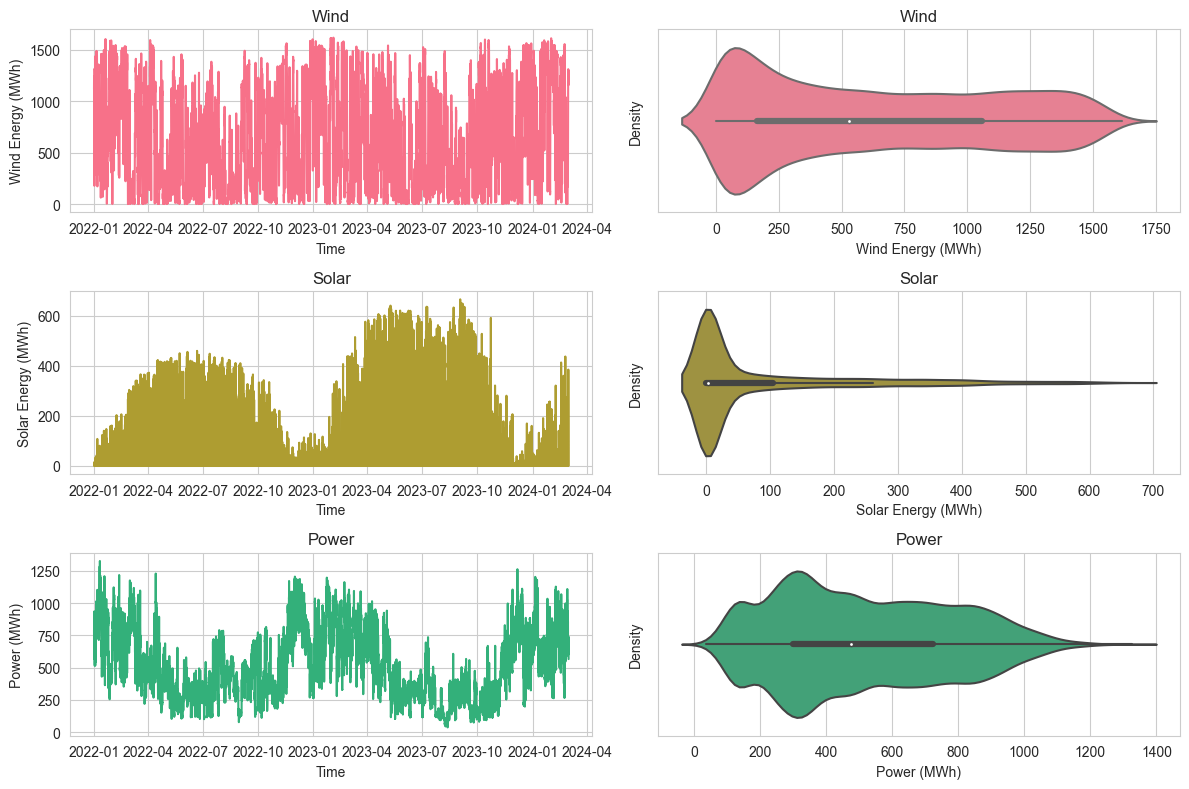

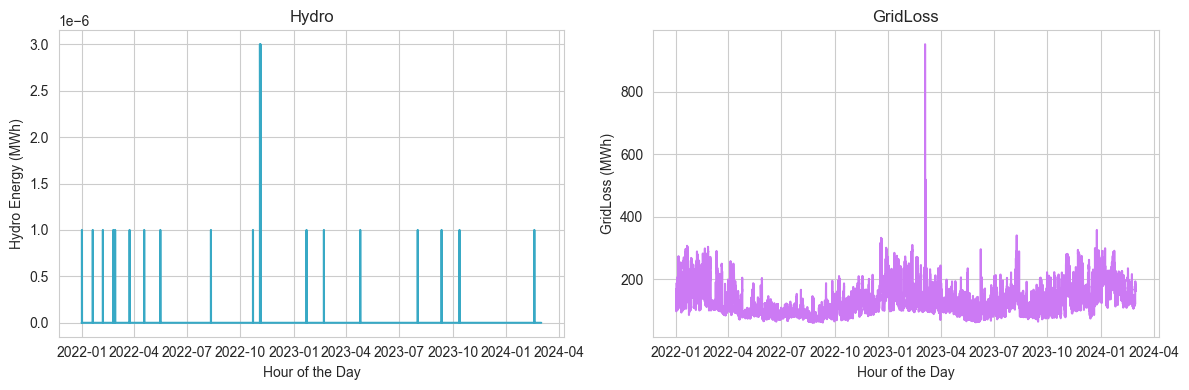

In [19]:
helpers.plot1(merged_df_DK2)

From this we can get an initial overview of the distributions of the energy. Especially that wind greatly fluctuates, but produces quite a large amount of power.

Solar power is cyclical especially during the 'summer' periods, but also has a large amount of down-time (we can also see this in the next plots)

Additionally, power is a pretty stable power production and never reaches 0 

Lastly Hydro is sparcely used, and barely produces anything, thus we may need to consider removing it. Additionally, grid loss amounts for a non-negligible power 'user'

Next we can plot the hourly development, also including the weather data: 

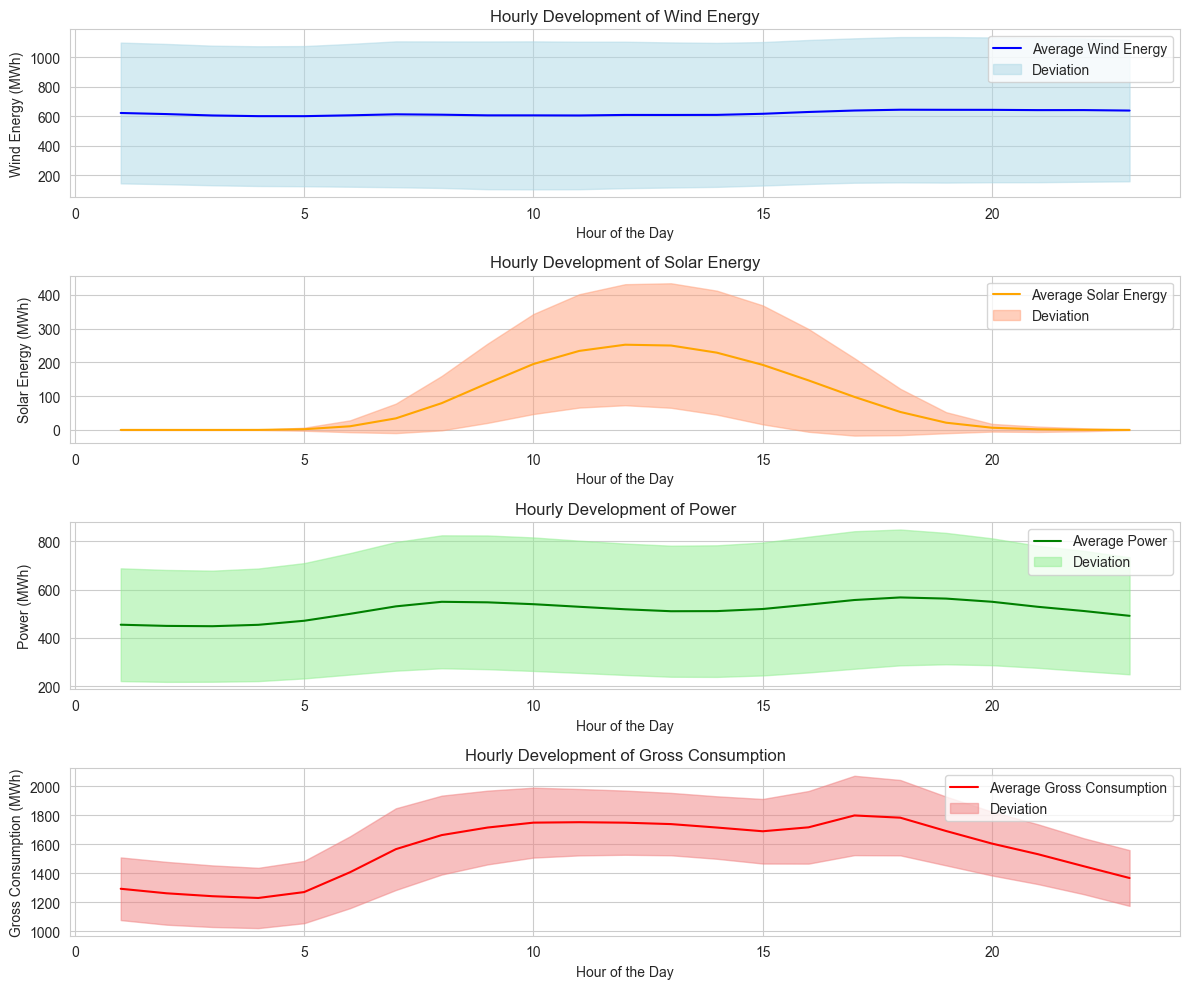

In [20]:
helpers.plot2(merged_df_DK2)

From the above plots, we can especially see the time dependence of solar energy. Additionally, the general power plants don't largely vary, but their average does seem to be multimodal around peak times. Possibly to anticipate peak demand around those times.

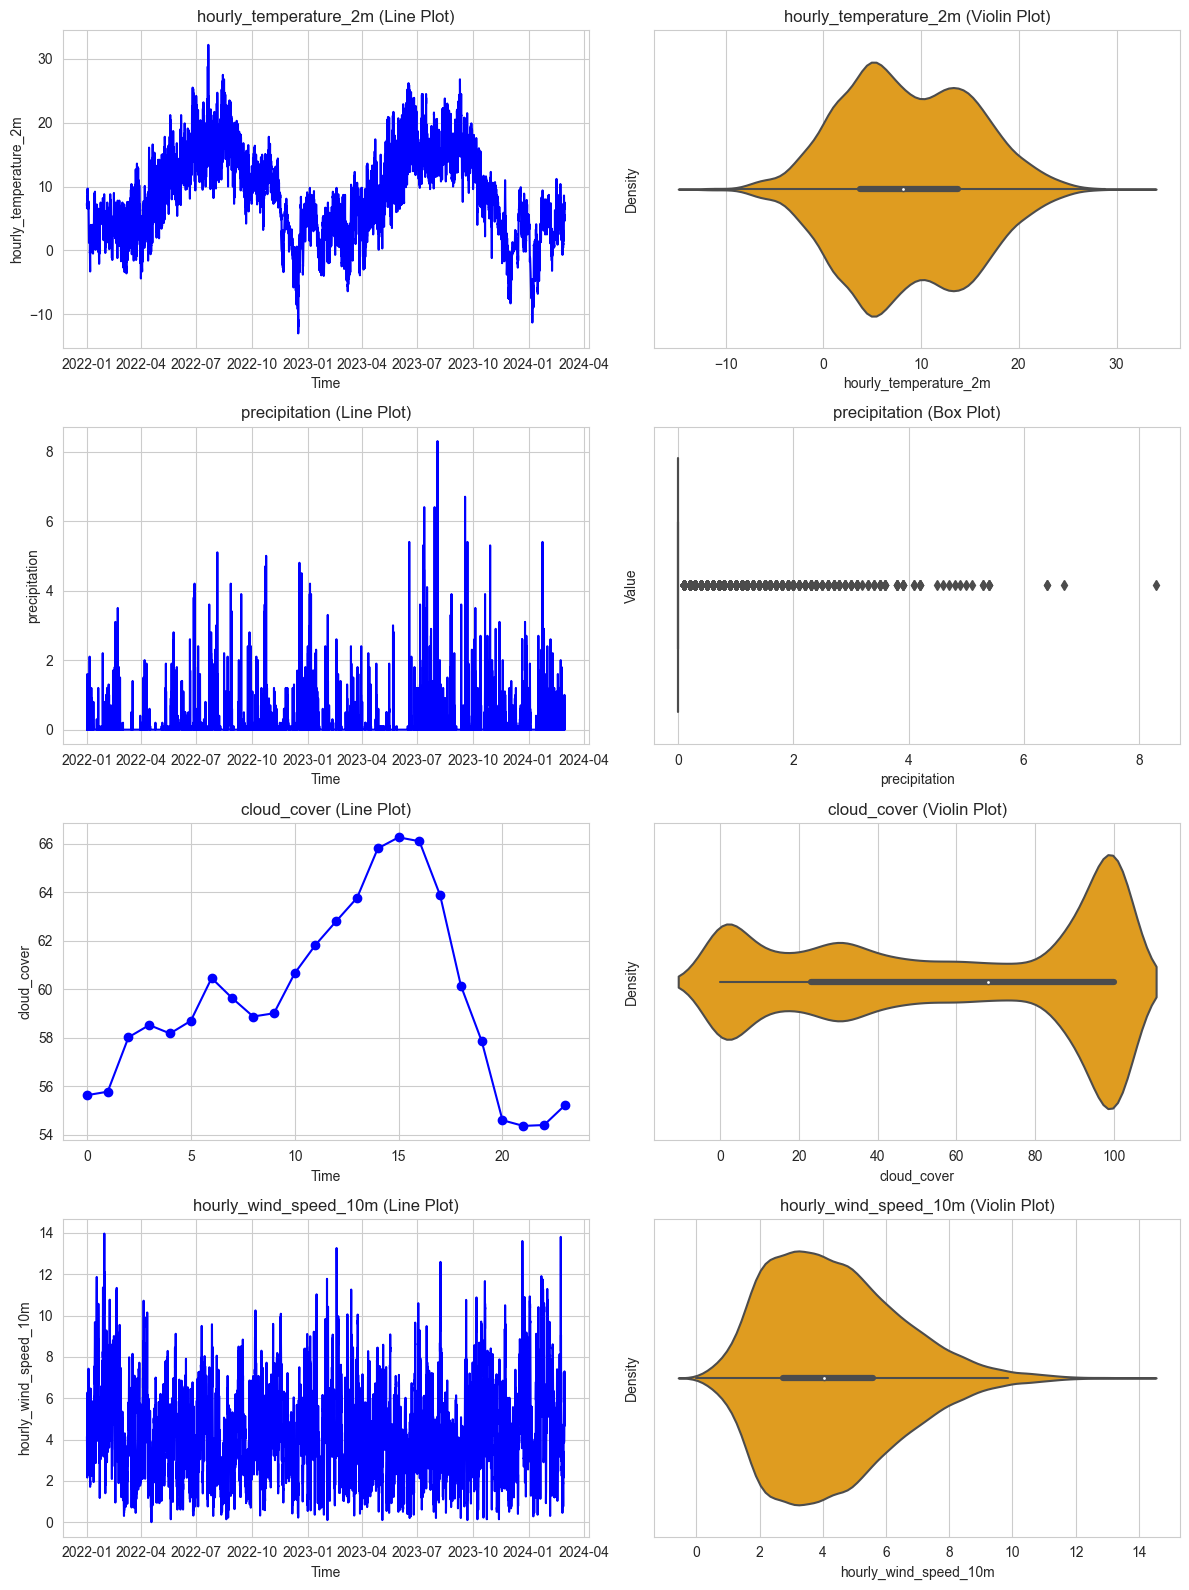

In [21]:
helpers.plot3(merged_df_DK2)

With regards to the weather data shown above, we can see that they are both dependent on the time of day and season, but also exhibit some degree of randomness such as with or precipitation

Next we can use a correlation plot to highlight the assumption of the weather having an influence on the power production, as well as on the consumption. Supporting the PGM we formulated

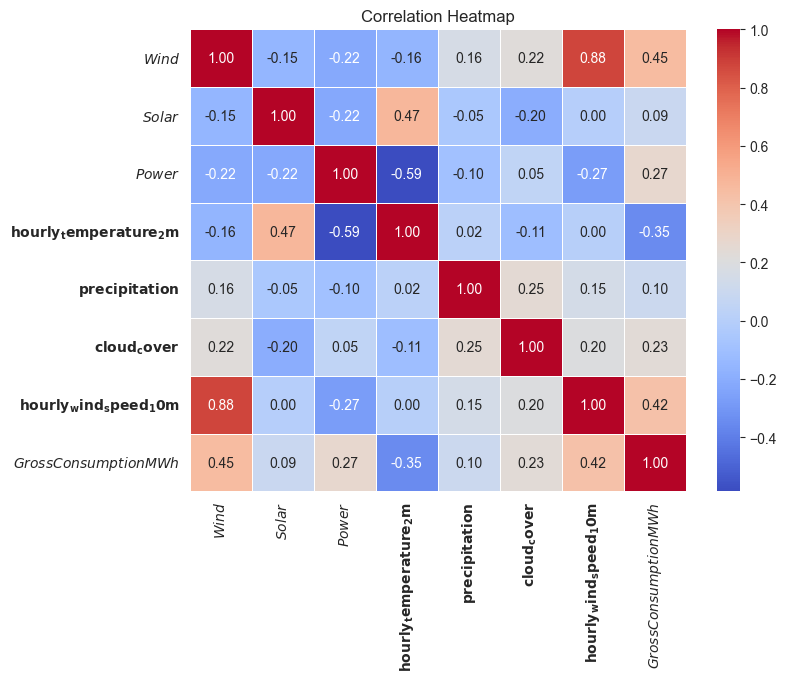

In [24]:
correlation_matrix = merged_df_DK1[['Wind', 'Solar', 'Power', 'hourly_temperature_2m', 'precipitation', 'cloud_cover', 'hourly_wind_speed_10m','GrossConsumptionMWh']].corr()
plt.figure(figsize=(8, 6))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
weather_features = ['hourly_temperature_2m', 'precipitation', 'cloud_cover', 'hourly_wind_speed_10m']
ax = plt.gca()
ax.set_xticklabels([f'$\mathbf{{{label}}}$' if label in weather_features else f'${label}$' for label in correlation_matrix.columns])
ax.set_yticklabels([f'$\mathbf{{{label}}}$' if label in weather_features else f'${label}$' for label in correlation_matrix.index])
plt.title('Correlation Heatmap')
plt.show()